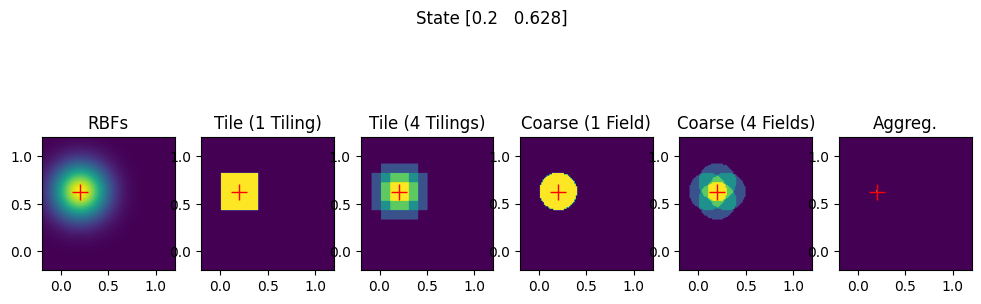

In [174]:
import numpy as np
import gymnasium
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

np.set_printoptions(precision=3, suppress=True)

# Notation for array sizes:
# - S: state dimensionality
# - D: features dimensionality
# - N: number of samples
#
# N is always the first dimension, meaning that states come in arrays of shape
# (N, S) and features in arrays of shape (N, D).
# We recommend to implement the functions below assuming that the input has
# always shape (N, S) and the output (N, D), even when N = 1.

def poly_features(state: np.array, degree: int) -> np.array:
    """
    Compute polynomial features. For example, if state = (s1, s2) and degree = 2,
    the output must be [1, s1, s2, s1*s2, s1**2, s2**2].
    """
    poly = PolynomialFeatures(degree=degree)
    return poly.fit_transform(state)

def rbf_features(
    state: np.array,  # (N, S)
    centers: np.array,  # (D, S)
    sigmas: float,
) -> np.array:  # (N, D)
    """
    Computes exp(- ||state - centers||**2 / sigmas**2 / 2).
    """
    # exp(- ||s - c||**2 / sigmas**2 / 2) = exp(- gamma ||s - c||**2)
    # gamma = 1 / w**2 / 2 = 1 / (2 w**2)
    gamma = 1 / (2 * sigmas**2)
    return rbf_kernel(X=state, Y=centers, gamma=gamma)

def tile_features(
    state: np.array,  # (N, S)
    centers: np.array,  # (D, S)
    widths: float,
    offsets: list = [(0, 0)],  # list of tuples of length S
) -> np.array:  # (N, D)
    """
    Given centers and widths, you first have to get an array of 0/1, with 1s
    corresponding to tile the state belongs to.
    If "offsets" is passed, it means we are using multiple tilings, i.e., we
    shift the centers according to the offsets and repeat the computation of
    the 0/1 array. The final output will sum the "activations" of all tilings.
    We recommend to normalize the output in [0, 1] by dividing by the number of
    tilings (offsets).
    Recall that tiles are squares, so you can't use the L2 Euclidean distance to
    check if a state belongs to a tile, but the L1 distance.
    """
    offsets = np.array(offsets)
    N, S = state.shape
    D = centers.shape[0]
    T = offsets.shape[0]

    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, S)  # (T, S)

    shifted_centers = centers[np.newaxis, :, :] + offsets[:, np.newaxis, :]  # (T, D, S)

    diff = state[:, np.newaxis, np.newaxis, :] - shifted_centers[np.newaxis, :, :, :]  # (N, T, D, S)
    abs_diff = np.abs(diff)  # (N, T, D, S)

    within_tile = np.all(abs_diff <= widths, axis=-1)  # (N, T, D)

    return np.sum(within_tile.astype(float), axis=1) / T


def coarse_features(
    state: np.array,  # (N, S)
    centers: np.array,  # (D, S)
    widths: float,
    offsets: list = [(0, 0)], # list of tuples of length S
) -> np.array:  # (N, D)
    """
    Same as tile coding, but we use circles instead of squares, so use the L2
    Euclidean distance to check if a state belongs to a circle.
    Note that coarse coding is more general and allows for ellipses (not just circles)
    but let's consider only circles for the sake of simplicity.
    """
    offsets = np.array(offsets)
    N, S = state.shape
    D = centers.shape[0]
    T = offsets.shape[0]

    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, S)  # (T, S)

    shifted_centers = centers[np.newaxis, :, :] + offsets[:, np.newaxis, :]  # (T, D, S)

    diff = state[:, np.newaxis, np.newaxis, :] - shifted_centers[np.newaxis, :, :, :]  # (N, T, D, S)
    dist_sq = np.sum(diff ** 2, axis=-1)  # (N, T, D)
    within_circle = dist_sq <= widths ** 2  # (N, T, D)

    return np.sum(within_circle.astype(float), axis=1) / T


def aggregation_features(state: np.array, centers: np.array) -> np.array:
    """
    Aggregate states to the closest center. The output will be an array of 0s and
    one 1 corresponding to the closest tile the state belongs to.
    Note that we can turn this into a discrete (finite) representation of the state,
    because we will have as many feature representations as centers.
    """
    distances = np.linalg.norm(state[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2, ord=1)
    return np.eye(len(centers))[np.argmin(distances, axis=1)]

state_size = 2
n_samples = 10
n_centers = 100
state = np.random.rand(n_samples, state_size)  # in [0, 1]

state_1_centers = np.linspace(-0.2, 1.2, n_centers)
state_2_centers = np.linspace(-0.2, 1.2, n_centers)
centers = np.array(
    np.meshgrid(state_1_centers, state_2_centers)
).reshape(state_size, -1).T  # makes a grid of uniformly spaced centers in the plane [-0.2, 1.2]^2
sigmas = 0.2
widths = 0.2
offsets = [(-0.1, 0.0), (0.0, 0.1), (0.1, 0.0), (0.0, -0.1)]

poly = poly_features(state, 2)
aggr = aggregation_features(state, centers)
rbf = rbf_features(state, centers, sigmas)
tile_one = tile_features(state, centers, widths)
tile_multi = tile_features(state, centers, widths, offsets)
coarse_one = coarse_features(state, centers, widths)
coarse_multi = coarse_features(state, centers, widths, offsets)

fig, axs = plt.subplots(1, 6, figsize=(12,4))
extent = [
    state_1_centers[0],
    state_1_centers[-1],
    state_2_centers[0],
    state_2_centers[-1],
]  # to change imshow axes
axs[0].imshow(rbf[0].reshape(n_centers, n_centers), extent=extent, origin='lower')
axs[1].imshow(tile_one[0].reshape(n_centers, n_centers), extent=extent, origin='lower')
axs[2].imshow(tile_multi[0].reshape(n_centers, n_centers), extent=extent, origin='lower')
axs[3].imshow(coarse_one[0].reshape(n_centers, n_centers), extent=extent, origin='lower')
axs[4].imshow(coarse_multi[0].reshape(n_centers, n_centers), extent=extent, origin='lower')
axs[5].imshow(aggr[0].reshape(n_centers, n_centers), extent=extent, origin='lower')
titles = ["RBFs", "Tile (1 Tiling)", "Tile (4 Tilings)", "Coarse (1 Field)", "Coarse (4 Fields)", "Aggreg."]  # we can't plot poly like this
for ax, title in zip(axs, titles):
    ax.plot(state[0][0], state[0][1], marker="+", markersize=12, color="red")
    ax.set_title(title)
plt.suptitle(f"State {state[0]}")
plt.show()

#################### PART 1
# Submit your heatmaps.
# What are the hyperparameters of each FA and how do they affect the shape of
# the function they can approximate?
# - In RBFs the hyperparameter(s) is/are ... More/less ... will affect ...,
#   while narrower/wider ... will affect ...
# - In tile/coarse coding the hyperparameter(s) is/are ...
# - In polynomials the hyperparameter(s) is/are ...
# - In state aggregation the hyperparameter(s) is/are ...

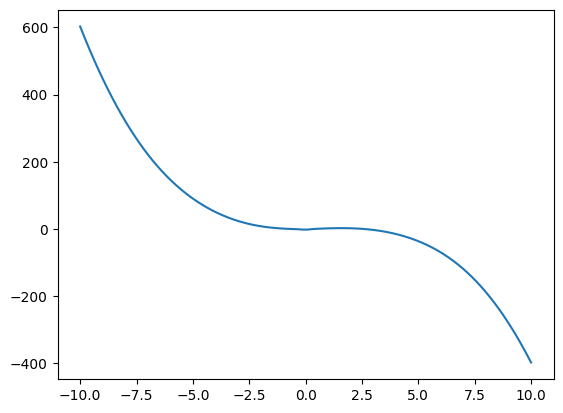

100%|██████████| 10000/10000 [00:00<00:00, 48207.40it/s]


Iterations: 9999, MSE: 2.161755972447568e-05, N. of Features 4


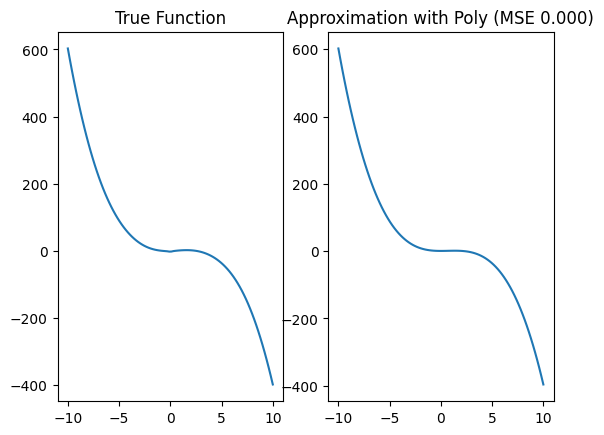

100%|██████████| 10000/10000 [00:00<00:00, 50222.46it/s]


Iterations: 9999, MSE: 0.0010467814402136016, N. of Features 10


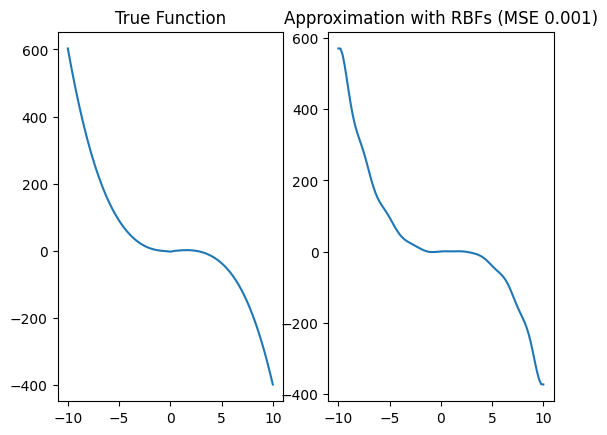

100%|██████████| 10000/10000 [00:00<00:00, 19315.39it/s]


Iterations: 9999, MSE: 0.0031575991134458383, N. of Features 21


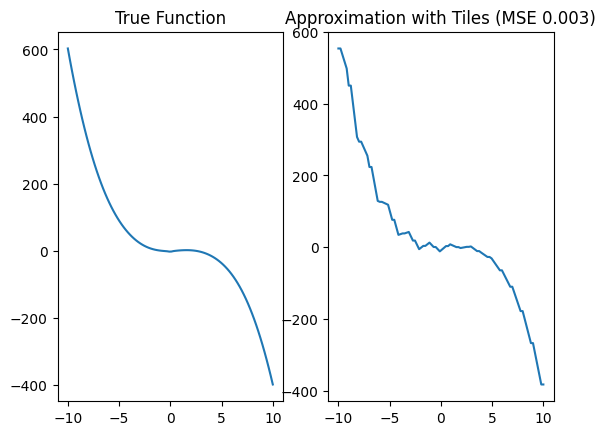

100%|██████████| 10000/10000 [00:00<00:00, 41248.82it/s]


Iterations: 9999, MSE: 0.0031575991134458383, N. of Features 21


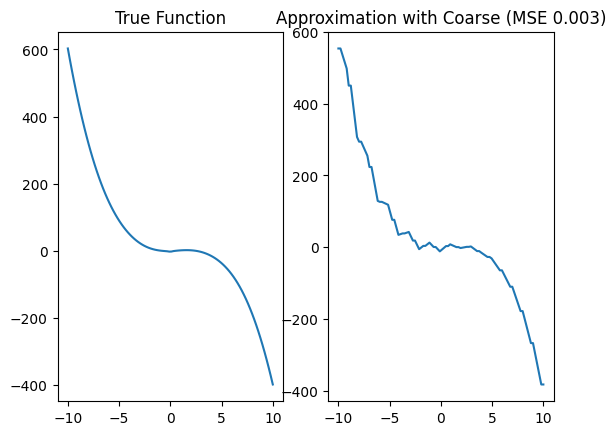

100%|██████████| 10000/10000 [00:00<00:00, 37454.76it/s]


Iterations: 9999, MSE: 0.009391590422144536, N. of Features 20


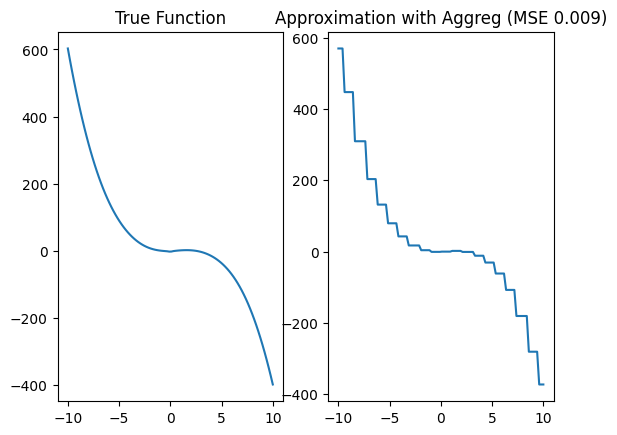

In [181]:
#################### PART 2
# Consider the function below.

x = np.linspace(-10, 10, 100)
y = np.sin(x) + x**2 - 0.5 * x**3 + np.log(np.abs(x))
fig, axs = plt.subplots(1, 1)
axs.plot(x, y)
plt.show()

# With SL, (try to) train a function with linear FA to fit y using gradient descent.
# Start with all weights to 0.
# Use all 5 FAs implemented earlier and submit your plots.
# Feel free to use a better learning rate (maybe check the book for suggestions).
#
# - Select the hyperparameters to achieve the best results (lowest MSE) with each
#   in 100000 iterations.
# - How would you change your hyperparameters if the 2nd element of the state would be
#   in the range [0, 1000] instead of [-10, 10]?
# - Would you change the implementation of RBFs and Tile Coding?
#
# Note: we don't want you to achieve MSE 0. Just have a decent plot with each FA,
# or discuss if some FA is not suitable to fit y, and report your plots.
# Anything like the demo plot is fine.


max_iter = 10_000
thresh = 1e-8

poly_degree = 3

rbf_centers = np.linspace(-10, 10, 10).reshape(-1, 1)
rbf_sigmas = 1.

num_tiles_per_dim = 21
tile_centers = np.linspace(-10, 10, num_tiles_per_dim).reshape(-1,1)
tile_widths = 20 / (num_tiles_per_dim - 1)
offsets = [0.0, 0.25, 0.5, 0.75]
tile_offsets = [tile_widths * dx for dx in offsets]



num_tiles_per_dim = 21
coarse_centers = np.linspace(-10, 10, num_tiles_per_dim).reshape(-1,1)
coarse_widths = 20 / (num_tiles_per_dim - 1)
offsets = [0.0, 0.25, 0.5, 0.75]
coarse_offsets = [coarse_widths * dx for dx in offsets]

agg_centers = np.linspace(-10, 10, 20).reshape(-1, 1)

# y normalization
y_mean = np.mean(y)
y_std = np.std(y)
y_scaled = (y - y_mean) / y_std

# l2 reg
lambda_reg = 1e-3

# grad clipping
max_grad = 1e2 

for name, get_phi in zip(["Poly", "RBFs", "Tiles", "Coarse", "Aggreg"],
    [
        lambda state : poly_features(state, degree=poly_degree),
        lambda state : rbf_features(state, centers=rbf_centers, sigmas=rbf_sigmas),
        lambda state : tile_features(state, centers=tile_centers, widths=tile_widths, offsets=tile_offsets),
        lambda state : coarse_features(state, centers=coarse_centers, widths=coarse_widths, offsets=coarse_offsets),
        lambda state : aggregation_features(state, centers=agg_centers),
    ]):

    alpha = 1e-2 if name in ["Poly", "RBFs", "Aggreg"] else 1e-4

    phi = get_phi(x[..., None])  # from (N,) to (N, S) with S = 1
    scaler = StandardScaler()
    phi_scaled = scaler.fit_transform(phi)
    weights = np.zeros(phi_scaled.shape[-1])
    for iter in tqdm(range(max_iter)):
        y_hat = np.dot(phi_scaled, weights)
        error = y_hat - y_scaled

        gradient = phi_scaled.T @ error + lambda_reg * weights
        gradient = np.clip(gradient, -max_grad, max_grad)
        weights -= alpha * gradient

        mse = np.mean(error ** 2)
        # pbar.set_description(f"MSE: {mse}")
        # pbar.update()
        if mse < thresh:
            break

    print(f"Iterations: {iter}, MSE: {mse}, N. of Features {len(weights)}")
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(x, y)
    axs[1].plot(x, y_hat * y_std + y_mean)
    axs[0].set_title("True Function")
    axs[1].set_title(f"Approximation with {name} (MSE {mse:.3f})")
    plt.show()

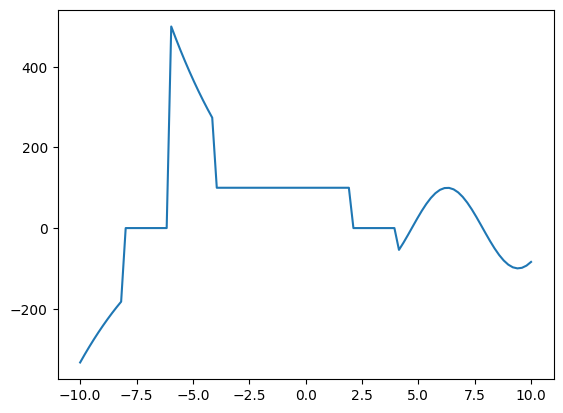

100%|██████████| 10000/10000 [00:00<00:00, 43095.68it/s]


Iterations: 9999, MSE: 0.2732762287969102, N. of Features 8


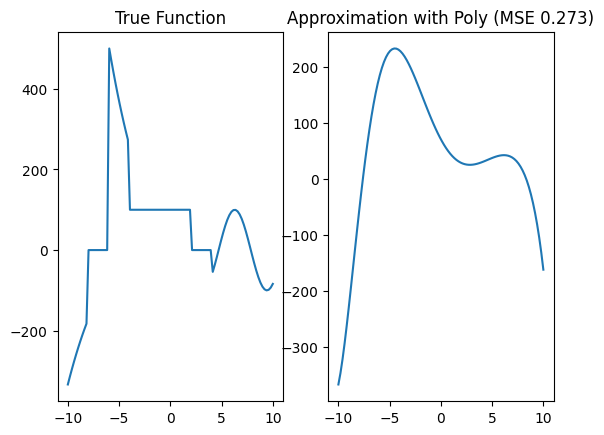

100%|██████████| 10000/10000 [00:00<00:00, 16142.50it/s]


Iterations: 9999, MSE: 0.06637844090611532, N. of Features 20


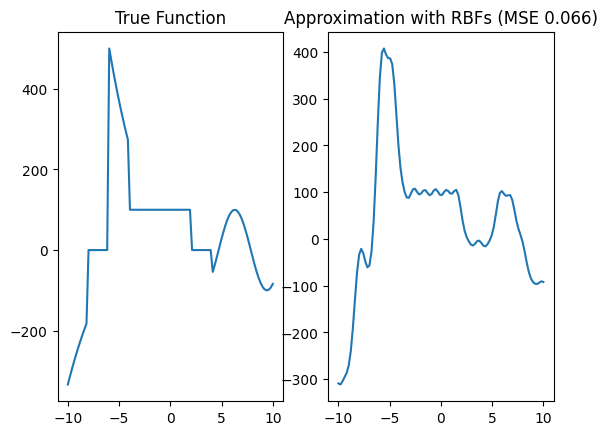

100%|██████████| 10000/10000 [00:00<00:00, 21073.75it/s]


Iterations: 9999, MSE: 0.03240533052876886, N. of Features 61


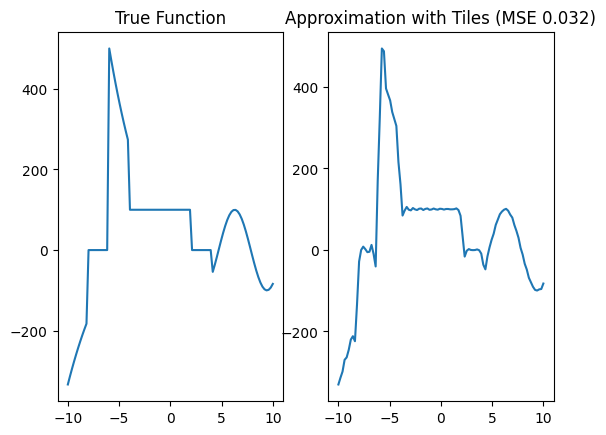

100%|██████████| 10000/10000 [00:00<00:00, 28429.29it/s]


Iterations: 9999, MSE: 0.03240533052876886, N. of Features 61


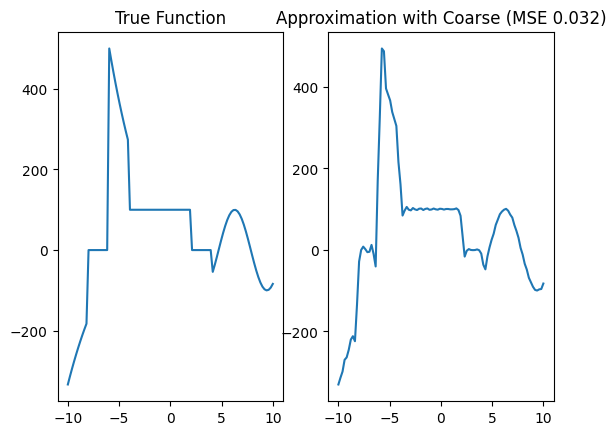

100%|██████████| 10000/10000 [00:00<00:00, 38510.98it/s]


Iterations: 9999, MSE: 0.0012465935437508749, N. of Features 60


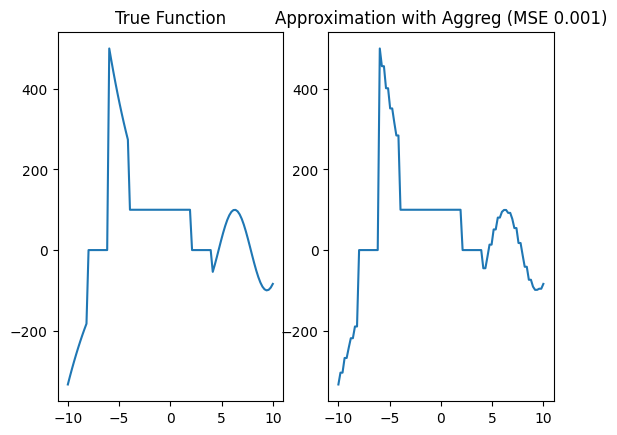

In [184]:
# Now repeat the experiment but fit the following function.
# Submit your plots and discuss your results, paying attention to the
# non-smoothness of the new target function.
# - How did you change your hyperparameters? Did you use more/less wider/narrower features?
# - Consider the number of features. How would it change if your state would be 2-dimensional?

x = np.linspace(-10, 10, 100)
y = np.zeros(x.shape)
y[0:10] = x[0:10]**3 / 3.0
y[10:20] = np.exp(x[25:35])
y[20:30] = -x[0:10]**3 / 2.0
y[30:60] = 100.0
y[60:70] = 0.0
y[70:100] = np.cos(x[70:100]) * 100.0
fig, axs = plt.subplots(1, 1)
axs.plot(x, y)
plt.show()


max_iter = 10_000
thresh = 1e-8

poly_degree = 7

rbf_centers = np.linspace(-10, 10, 20).reshape(-1, 1)
rbf_sigmas = 0.5

num_tiles_per_dim = 61
tile_centers = np.linspace(-10, 10, num_tiles_per_dim).reshape(-1,1)
tile_widths = 20 / (num_tiles_per_dim - 1)
offsets = [0.0, 0.25, 0.5, 0.75]
tile_offsets = [tile_widths * dx for dx in offsets]



num_tiles_per_dim = 61
coarse_centers = np.linspace(-10, 10, num_tiles_per_dim).reshape(-1,1)
coarse_widths = 20 / (num_tiles_per_dim - 1)
offsets = [0.0, 0.25, 0.5, 0.75]
coarse_offsets = [coarse_widths * dx for dx in offsets]

agg_centers = np.linspace(-10, 10, 60).reshape(-1, 1)

# y normalization
y_mean = np.mean(y)
y_std = np.std(y)
y_scaled = (y - y_mean) / y_std

# l2 reg
lambda_reg = 1e-3

# grad clipping
max_grad = 1e2 

for name, get_phi in zip(["Poly", "RBFs", "Tiles", "Coarse", "Aggreg"],
    [
        lambda state : poly_features(state, degree=poly_degree),
        lambda state : rbf_features(state, centers=rbf_centers, sigmas=rbf_sigmas),
        lambda state : tile_features(state, centers=tile_centers, widths=tile_widths, offsets=tile_offsets),
        lambda state : coarse_features(state, centers=coarse_centers, widths=coarse_widths, offsets=coarse_offsets),
        lambda state : aggregation_features(state, centers=agg_centers),
    ]):

    alpha = 5e-4 if name in ["Poly"] else 1e-3
    alpha = 1e-2 if name in ["Aggreg"] else alpha
    alpha = 1e-3 if name in ["RBFs"] else alpha

    phi = get_phi(x[..., None])  # from (N,) to (N, S) with S = 1
    scaler = StandardScaler()
    phi_scaled = scaler.fit_transform(phi)
    weights = np.zeros(phi_scaled.shape[-1])
    for iter in tqdm(range(max_iter)):
        y_hat = np.dot(phi_scaled, weights)
        error = y_hat - y_scaled

        gradient = phi_scaled.T @ error + lambda_reg * weights
        gradient = np.clip(gradient, -max_grad, max_grad)
        weights -= alpha * gradient

        mse = np.mean(error ** 2)
        # pbar.set_description(f"MSE: {mse}")
        # pbar.update()
        if mse < thresh:
            break

    print(f"Iterations: {iter}, MSE: {mse}, N. of Features {len(weights)}")
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(x, y)
    axs[1].plot(x, y_hat * y_std + y_mean)
    axs[0].set_title("True Function")
    axs[1].set_title(f"Approximation with {name} (MSE {mse:.3f})")
    plt.show()


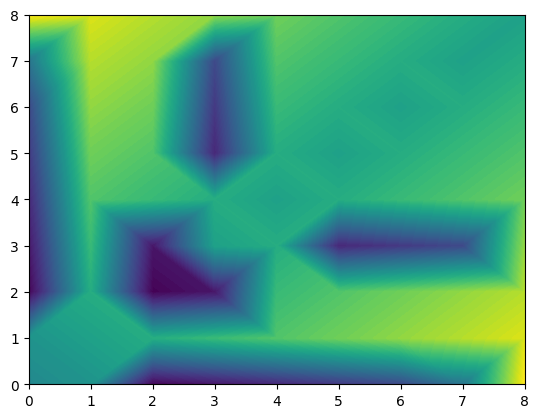

100%|██████████| 40000/40000 [02:03<00:00, 323.80it/s]


Iterations: 39999, MSE: 2.0400383218104383e-05, N. of Features 289


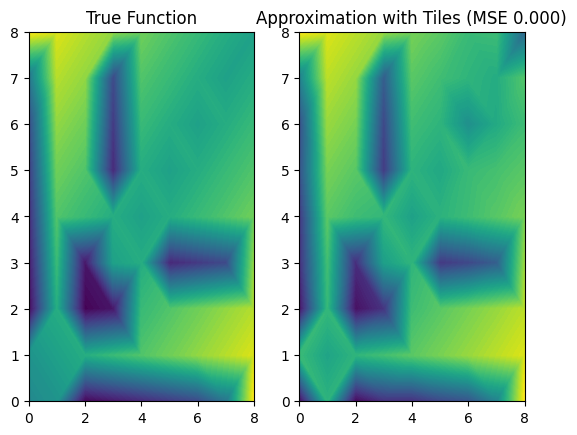

In [197]:
#################### PART 3
# Consider the Gridworld depicted below. The dataset below contains episodes
# collected using the optimal policy, and the heatmap below shows its V-function.
# - Consider the 5 FAs implemented earlier and discuss why each would be a
#   good/bad choice. Discuss each in at most two sentences.

# These data is a dictionary of (s, a, r, s', term, Q).
# - Run batch semi-gradient TD prediction with a FA of your choice (the one you
#   think would work best) to learn an approximation of the V-function.
#   Use gamma = 0.99. Increase the number of iterations, if you'd like.
#   Plot your result of the true V-function against your approximation using the
#   provided plotting function.


data = np.load("a6_gridworld.npz")
s = data["s"]
a = data["a"]
r = data["r"]
s_next = data["s_next"]
Q = data["Q"]
V = data["Q"].max(-1)  # value of the greedy policy
term = data["term"]
n = s.shape[0]

fig, axs = plt.subplots(1, 1)
axs.tricontourf(s[:, 0], s[:, 1], V, levels=100)
plt.show()

max_iter = 40_000
gamma = 0.99
alpha = 0.01
thresh = 1e-8


num_tiles_per_dim = 17
x_centers = np.linspace(0, 8, num_tiles_per_dim)
y_centers = np.linspace(0, 8, num_tiles_per_dim)
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)
tile_centers = np.vstack([X_centers.ravel(), Y_centers.ravel()]).T 

tile_widths = 12 / (num_tiles_per_dim - 1)
# offsets = [0.0, 0.25, 0.5, 0.75]
offsets = [0.0, 0.25]
tile_offsets = [(tile_widths * dx, tile_widths * dy) for dx in offsets for dy in offsets]

name, get_phi = "Tiles", lambda state : tile_features(state, centers=tile_centers, widths=tile_widths, offsets=tile_offsets)

phi = get_phi(s)
phi_next = get_phi(s_next)

weights = np.zeros(phi.shape[-1])
# pbar = tqdm(total=max_iter)
for iter in tqdm(range(max_iter)):
    # do TD semi-gradient
    # V_s = phi_scaled @ weights
    # V_s_next = phi_next_scaled @ weights
    V_s = phi @ weights
    V_s_next = phi_next @ weights
    td_error = r + gamma * (1-term) * V_s_next - V_s

    gradient = phi.T @ td_error / n

    weights += alpha * gradient
    mse = np.mean((V_s - V) ** 2)
    # pbar.set_description(f"TDE: {td_error}, MSE: {mse}")
    # pbar.update()
    if mse < thresh:
        break

print(f"Iterations: {iter}, MSE: {mse}, N. of Features {len(weights)}")
fig, axs = plt.subplots(1, 2)
axs[0].tricontourf(s[:, 0], s[:, 1], V, levels=100)
axs[1].tricontourf(s[:, 0], s[:, 1], V_s, levels=100)
axs[0].set_title("True Function")
axs[1].set_title(f"Approximation with Tiles (MSE {mse:.3f})")
plt.show()

100%|██████████| 20000/20000 [00:31<00:00, 629.90it/s]


Iterations: 19999, MSE: 0.4197466634901829, N. of Features 81


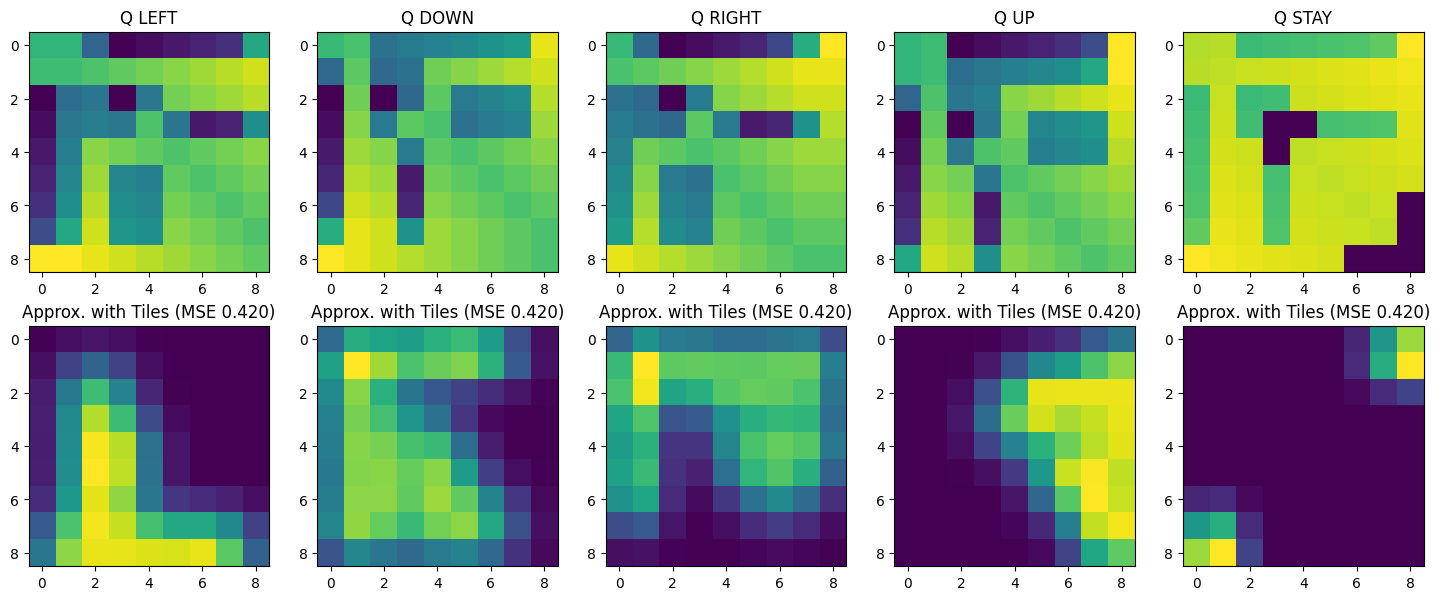

In [244]:

#################### PART 4
# - Run TD again, but this time learn an approximation of the Q-function.
#   How did you have to change your code?

max_iter = 20_000
gamma = 0.99
alpha = 0.01
thresh = 1e-8


num_tiles_per_dim = 9
x_centers = np.linspace(0, 8, num_tiles_per_dim)
y_centers = np.linspace(0, 8, num_tiles_per_dim)
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)
tile_centers = np.vstack([X_centers.ravel(), Y_centers.ravel()]).T 

tile_widths = 8 / (num_tiles_per_dim - 1)
offsets = [0.0, 0.25, 0.5, 0.75]
# offsets = [0.0, 0.25]
tile_offsets = [(tile_widths * dx, tile_widths * dy) for dx in offsets for dy in offsets]

name, get_phi = "Tiles", lambda state : tile_features(state, centers=tile_centers, widths=tile_widths, offsets=tile_offsets)

phi = get_phi(s)
phi_next = get_phi(s_next)

r = r.flatten()       
term = term.flatten() 
a = a.flatten()       

weights = np.zeros((phi.shape[-1], 5)) # including the actions
# pbar = tqdm(total=max_iter)
for iter in tqdm(range(max_iter)):
    Q_s = phi @ weights
    Q_s_next = phi_next @ weights

    Q_s_a = Q_s[np.arange(n), a]
    Q_s_next_max = np.max(Q_s_next, axis=1)

    td_error = r + gamma * (1 - term) * Q_s_next_max - Q_s_a 
    td_error_full = np.zeros_like(Q_s)
    td_error_full[np.arange(n), a] = td_error

    gradient = phi.T @ td_error_full / n
    weights += alpha * gradient

    mse = np.mean((Q_s - Q) ** 2)
    # pbar.set_description(f"TDE: {td_error}, MSE: {mse}")
    # pbar.update()
    if mse < thresh:
        break

n_states = 81
n_actions = 5
s_idx = np.ravel_multi_index(s.T, (9, 9))
unique_s_idx = np.unique(s_idx, return_index=True)[1]

print(f"Iterations: {iter}, MSE: {mse}, N. of Features {len(weights)}")
fig, axs = plt.subplots(2, n_actions, figsize=(18,7))
for i, j in zip(range(n_actions), ["LEFT", "DOWN", "RIGHT", "UP", "STAY"]):
    axs[0][i].imshow(Q[unique_s_idx, i].reshape(9, 9))
    axs[1][i].imshow(Q_s[unique_s_idx, i].reshape(9, 9))
    axs[0][i].set_title(f"Q {j}")
    axs[1][i].set_title(f"Approx. with Tiles (MSE {mse:.3f})")
plt.show()


In [ ]:
#################### PART 5
# Discuss similarities and differences between SL regression and RL TD.
# - Discuss loss functions, techniques applicable to minimize it, and additional
#   challenges of RL.
# - What are the differences between "gradient descent" and "semi-gradient
#   descent" for TD?
# - Assume you'd have to learn the Q-function when actions are continuous.
#   How would you change your code?